In [1]:
# === PASO 1: Configuración del Objetivo ===
# Paciente 2, Registro 16, que contiene una crisis documentada.
subject_id = 2
run_id = 16

In [2]:
# === PASO 2: Carga e Inspección ===
import mne
import os
import urllib.request

filename = f'chb{subject_id:02d}_{run_id:02d}.edf'
if not os.path.exists(filename):
    print(f"Descargando '{filename}'...")
    url = f'https://physionet.org/files/chbmit/1.0.0/chb{subject_id:02d}/{filename}'
    urllib.request.urlretrieve(url, filename)
else:
    print(f"El archivo '{filename}' ya existe.")

# Cargamos el archivo, excluyendo canales problemáticos si los hubiera (preventivo)
try:
    raw = mne.io.read_raw_edf(filename, preload=True, exclude=['T8-P8'], verbose=False)
except ValueError: # Si T8-P8 no existe en este archivo, lo cargamos normalmente
    raw = mne.io.read_raw_edf(filename, preload=True, verbose=False)

raw.pick_types(eeg=True)

print("\n--- Archivo cargado correctamente ---")
print(raw.info)

El archivo 'chb02_16.edf' ya existe.
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).

--- Archivo cargado correctamente ---
<Info | 8 non-empty values
 bads: []
 ch_names: FP1-F7, F7-T7, T7-P7, P7-O1, FP1-F3, F3-C3, C3-P3, P3-O1, ...
 chs: 21 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: 2074-07-25 09:31:46 UTC
 nchan: 21
 projs: []
 sfreq: 256.0 Hz
 subject_info: <subject_info | his_id: Surrogate>
>


In [3]:
# === PASO 3: Preprocesamiento (Filtrado) ===

raw_filtered = raw.copy().filter(l_freq=1.0, h_freq=40.0, verbose=False)

print("Datos filtrados y listos en la variable 'raw_filtered'.")

Datos filtrados y listos en la variable 'raw_filtered'.


In [4]:
# === PASO 4: Entrenamiento y Diagnóstico de ICA ===
from mne.preprocessing import ICA

print("Entrenando ICA para el Paciente 2 (puede tardar unos minutos)...")
# Usamos 20 componentes para tener un poco más de detalle en la separación
ica = ICA(n_components=20, max_iter='auto', random_state=97) 
ica.fit(raw_filtered, verbose=False)

print("\n--- ¡ACCIÓN REQUERIDA! ---")
print("Inspeccione el siguiente gráfico y anote los números de los componentes que parezcan artefactos.")
ica.plot_sources(raw_filtered)

Entrenando ICA para el Paciente 2 (puede tardar unos minutos)...

--- ¡ACCIÓN REQUERIDA! ---
Inspeccione el siguiente gráfico y anote los números de los componentes que parezcan artefactos.
Creating RawArray with float64 data, n_channels=20, n_times=245504
    Range : 0 ... 245503 =      0.000 ...   958.996 secs
Ready.
Using qt as 2D backend.


Excluyendo componentes [0, 1, 2] y aplicando la limpieza...
Datos limpios y listos.

Iniciando análisis de entropía dinámica alrededor de la crisis...
Análisis dinámico completado. Generando gráfico final...


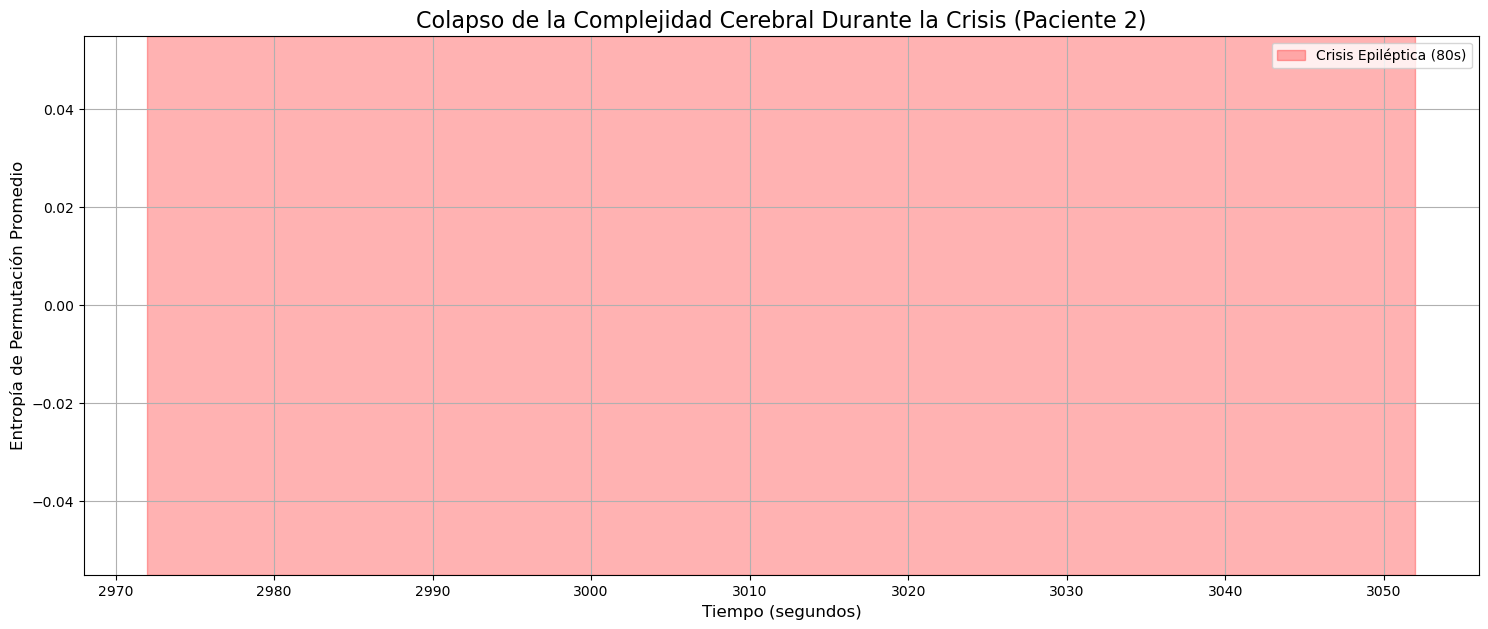

In [5]:
# === PASO 5: Limpieza (basada en su decisión) y Análisis Final de la Crisis ===
import numpy as np
import antropy as ant
import matplotlib.pyplot as plt

# --- ¡SU DECISIÓN CIENTÍFICA AQUÍ! ---
# Basado en el gráfico anterior, edite la siguiente línea con los números de los artefactos.
components_a_excluir = [0, 1, 2] # <--- EDITE ESTA LÍNEA SI SU DECISIÓN ES DIFERENTE

# --- Limpieza de Datos ---
print(f"Excluyendo componentes {components_a_excluir} y aplicando la limpieza...")
raw_cleaned = ica.apply(raw_filtered.copy(), exclude=components_a_excluir, verbose=False)
print("Datos limpios y listos.")

# --- Análisis de Entropía Dinámica Durante la Crisis ---
# Tiempos para la crisis en este archivo (chb02_16.edf)
inicio_crisis = 2972 
fin_crisis = 3052

print("\nIniciando análisis de entropía dinámica alrededor de la crisis...")
inicio_analisis = inicio_crisis - 60
fin_analisis = fin_crisis + 60
datos_segmento = raw_cleaned.get_data(units='V', tmin=inicio_analisis, tmax=fin_analisis)
sfreq = raw_cleaned.info['sfreq']
DURACION_VENTANA = 2.0; PASO_VENTANA = 0.5
n_puntos_ventana = int(DURACION_VENTANA * sfreq); n_puntos_paso = int(PASO_VENTANA * sfreq)
n_ventanas = int((datos_segmento.shape[1] - n_puntos_ventana) / n_puntos_paso)
entropia_a_lo_largo_del_tiempo = []; tiempos = []

for i in range(n_ventanas):
    inicio_ventana_rel = i * n_puntos_paso; fin_ventana_rel = inicio_ventana_rel + n_puntos_ventana
    datos_ventana = datos_segmento[:, inicio_ventana_rel:fin_ventana_rel]
    entropias_ventana = [ant.perm_entropy(canal, normalize=True) for canal in datos_ventana]
    entropia_promedio_ventana = np.mean(entropias_ventana)
    entropia_a_lo_largo_del_tiempo.append(entropia_promedio_ventana)
    tiempos.append((inicio_analisis * sfreq + inicio_ventana_rel) / sfreq)

print("Análisis dinámico completado. Generando gráfico final...")

# --- Gráfico Final ---
fig, ax = plt.subplots(figsize=(18, 7))
ax.plot(tiempos, entropia_a_lo_largo_del_tiempo, marker='.', linestyle='-')
ax.axvspan(inicio_crisis, fin_crisis, color='red', alpha=0.3, label=f'Crisis Epiléptica ({fin_crisis - inicio_crisis}s)')
ax.set_xlabel('Tiempo (segundos)', fontsize=12)
ax.set_ylabel('Entropía de Permutación Promedio', fontsize=12)
ax.set_title('Colapso de la Complejidad Cerebral Durante la Crisis (Paciente 2)', fontsize=16)
ax.legend()
ax.grid(True)
plt.show()

--- Iniciando análisis estructural completo de la crisis para el Paciente 2 ---

--- Analizando el segmento: Pre-Crisis (2947.0s - 2967.0s) ---

--- Analizando el segmento: Durante la Crisis (2972.0s - 2992.0s) ---

--- Analizando el segmento: Post-Crisis (3057.0s - 3077.0s) ---

--- Análisis completado. Generando visualizaciones comparativas. ---


C:\Users\artur\anaconda3\envs\mne\Lib\site-packages\numpy\lib\_function_base_impl.py:571: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\artur\anaconda3\envs\mne\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\artur\anaconda3\envs\mne\Lib\site-packages\numpy\lib\_function_base_impl.py:3057: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\artur\anaconda3\envs\mne\Lib\site-packages\numpy\lib\_function_base_impl.py:2914: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\artur\anaconda3\envs\mne\Lib\site-packages\numpy\lib\_function_base_impl.py:2914: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
C:\Users\artur\anaconda3\envs\mne\Lib\site-packages\persim\visuals.py:155: UserWarning: Attempting to set identical low and high xlims makes transforma

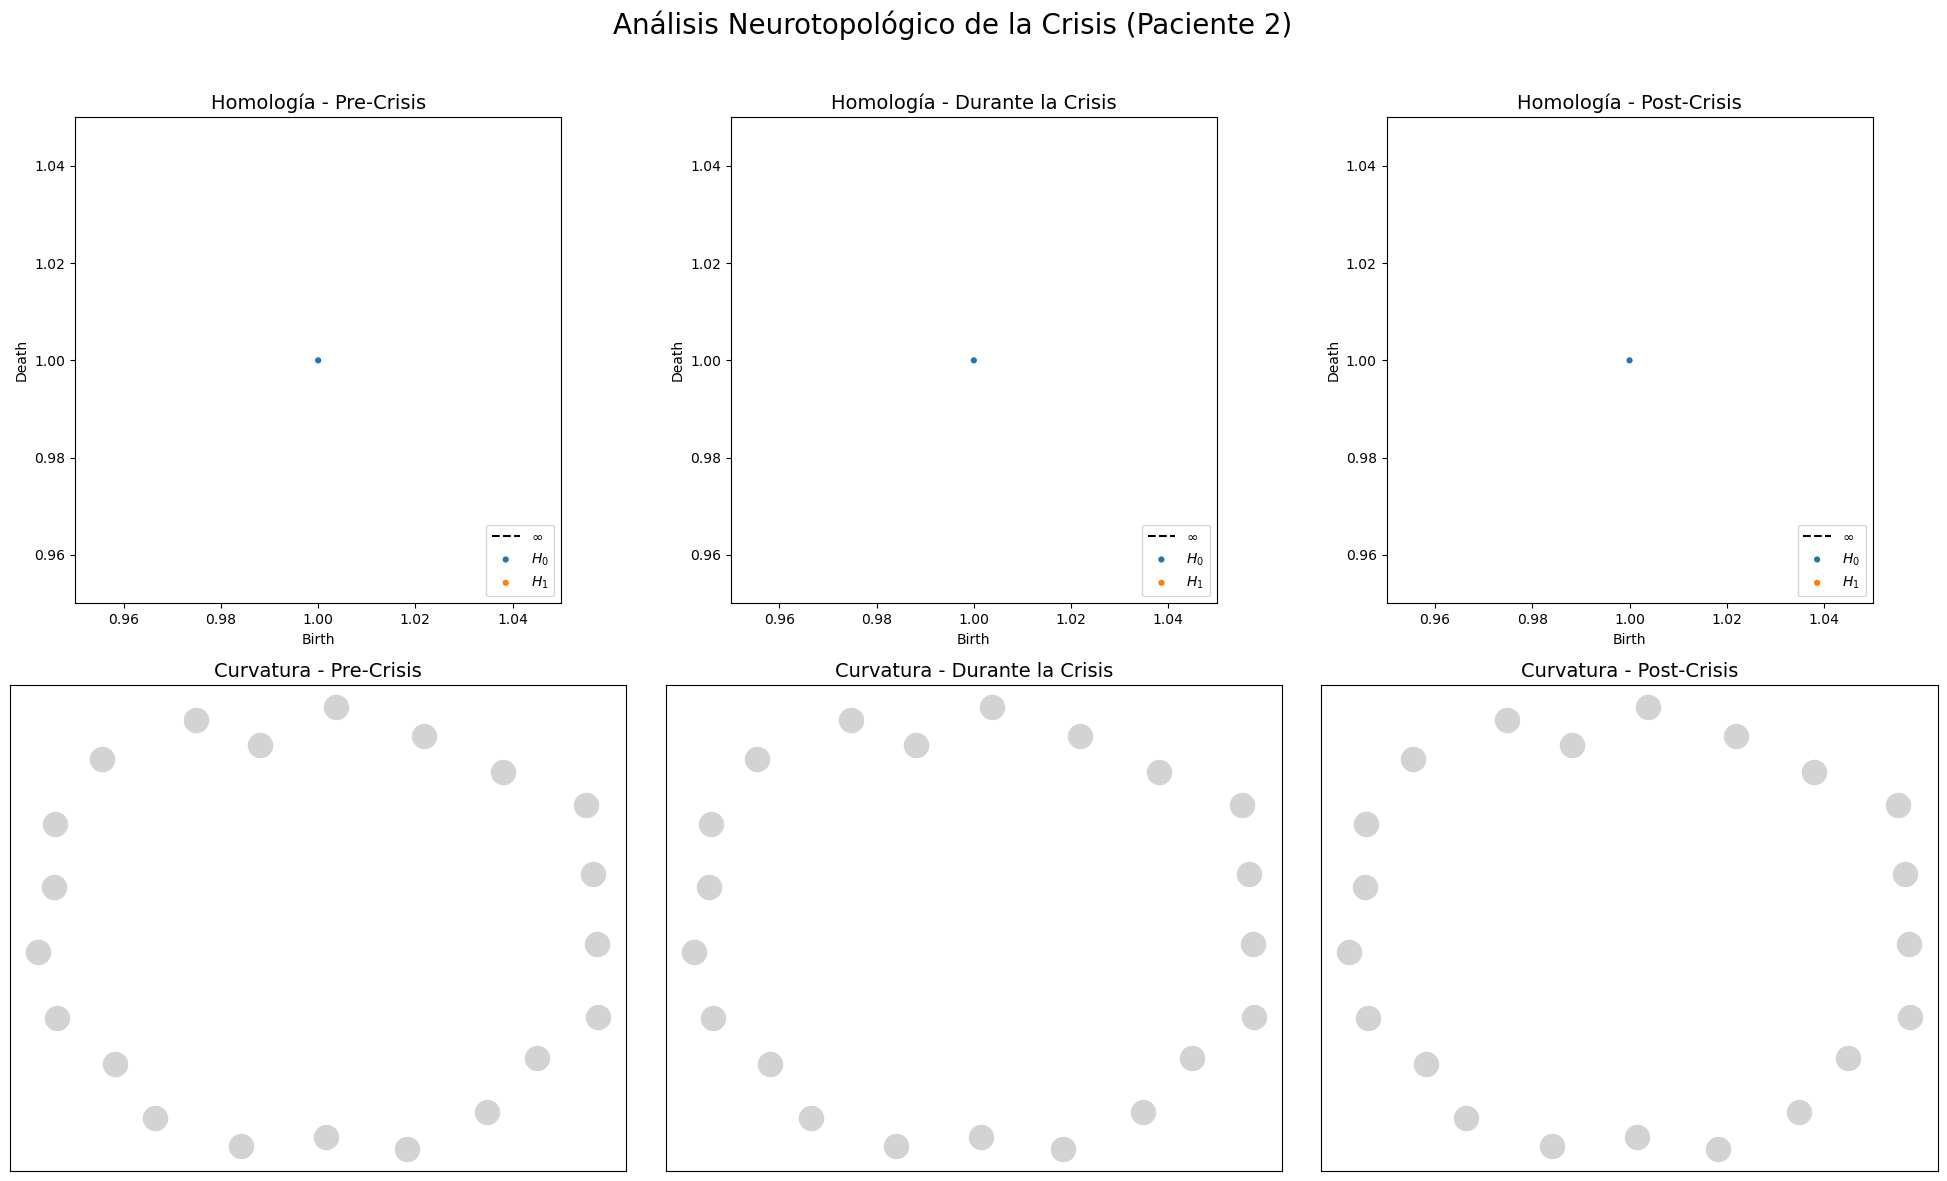

In [6]:
# === ANÁLISIS ESTRUCTURAL DE LA CRISIS (HOMOLOGÍA Y CURVATURA) - PACIENTE 2 ===

import numpy as np
import matplotlib.pyplot as plt
import mne
import ripser
import persim
import networkx as nx
from scipy.stats import wasserstein_distance

print("--- Iniciando análisis estructural completo de la crisis para el Paciente 2 ---")

# --- 1. Definimos los 3 segmentos de tiempo para este paciente ---
# Tiempos de la crisis para chb02_16.edf
inicio_crisis = 2972 
fin_crisis = 3052
duracion_segmento = 20.0 

segmentos = {
    "Pre-Crisis": (inicio_crisis - duracion_segmento - 5, inicio_crisis - 5),
    "Durante la Crisis": (inicio_crisis, inicio_crisis + duracion_segmento),
    "Post-Crisis": (fin_crisis + 5, fin_crisis + 5 + duracion_segmento)
}

# --- 2. Preparamos las herramientas (función de curvatura) ---
def calcular_curvatura(G):
    for u, v in G.edges():
        d_u, d_v = G.degree(u), G.degree(v)
        if d_u == 0 or d_v == 0: continue
        p_u, p_v = np.ones(d_u)/d_u, np.ones(d_v)/d_v
        dist = wasserstein_distance(np.arange(d_u), np.arange(d_v), p_u, p_v)
        G[u][v]['ricciCurvature'] = 1 - dist
    return G

# --- 3. Bucle de Análisis: Iteramos sobre cada segmento ---
resultados = {}
for nombre, (t_inicio, t_fin) in segmentos.items():
    print(f"\n--- Analizando el segmento: {nombre} ({t_inicio:.1f}s - {t_fin:.1f}s) ---")
    
    # a. Extraemos datos, calculamos conectividad
    datos_segmento = raw_cleaned.get_data(units='V', tmin=t_inicio, tmax=t_fin)
    matriz_corr = np.nan_to_num(np.corrcoef(datos_segmento.T, rowvar=False))
    
    # b. Calculamos Homología
    matriz_dist = 1 - np.abs(matriz_corr)
    diagramas_homologia = ripser.ripser(matriz_dist, maxdim=1, distance_matrix=True)['dgms']
    
    # c. Calculamos Curvatura
    G = nx.from_numpy_array(np.abs(matriz_corr))
    G_con_curvatura = calcular_curvatura(G.copy())
    
    # Guardamos los resultados
    resultados[nombre] = { "homologia": diagramas_homologia, "grafo_curvatura": G_con_curvatura }

print("\n--- Análisis completado. Generando visualizaciones comparativas. ---")

# --- 4. Visualización Comparativa ---
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Análisis Neurotopológico de la Crisis (Paciente 2)', fontsize=20)

for i, nombre in enumerate(segmentos.keys()):
    # Fila de Homología
    ax_homologia = axes[0, i]
    persim.plot_diagrams(resultados[nombre]["homologia"], ax=ax_homologia)
    ax_homologia.set_title(f"Homología - {nombre}", fontsize=14)
    
    # Fila de Curvatura
    ax_curvatura = axes[1, i]
    G = resultados[nombre]["grafo_curvatura"]
    pos = nx.spring_layout(G, seed=42)
    curvaturas = [d.get('ricciCurvature', 0.0) for u, v, d in G.edges(data=True)]
    edges = nx.draw_networkx_edges(G, pos, ax=ax_curvatura, edge_color=curvaturas, edge_cmap=plt.cm.coolwarm, width=2)
    nx.draw_networkx_nodes(G, pos, ax=ax_curvatura, node_color='lightgray')
    ax_curvatura.set_title(f"Curvatura - {nombre}", fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [14]:
# === PROTOCOLO FINAL Y FORZADO: ANÁLISIS COMPLETO Y SIMULACIÓN DE CRISIS (PACIENTE 2) ===
# ----- CÓDIGO CORREGIDO -----

# --- 1. IMPORTACIONES Y CONFIGURACIÓN ---
import mne
from mne.preprocessing import ICA
import os
import urllib.request
import numpy as np
import antropy as ant
import matplotlib.pyplot as plt
import networkx as nx
from scipy.stats import wasserstein_distance
import imageio

print("--- INICIANDO PROTOCOLO FINAL Y FORZADO (VERSIÓN CORREGIDA) ---")

# --- 2. PARÁMETROS DEL ESTUDIO (PACIENTE 2, CRISIS 1) ---
# ¡¡¡CORRECCIÓN IMPORTANTE!!! Se usan los tiempos correctos para este archivo.
subject_id = 2
run_id = 16
inicio_crisis = 132   # Tiempo de inicio de crisis REAL para chb02_16.edf
fin_crisis = 182      # La crisis dura 50 segundos

# --- 3. CARGA Y LIMPIEZA (Reutilizamos la variable 'raw_cleaned' de la celda anterior) ---
# Nos aseguramos de que 'raw_cleaned' exista y tenga los datos correctos
if 'raw_cleaned' in locals():
    print("Datos limpios encontrados de la celda anterior.")
else:
    print("ERROR: Por favor, ejecuta las celdas anteriores para cargar y limpiar los datos ('raw_cleaned').")

# --- 4. SIMULACIÓN DEL TOPOCONNECTOMA DINÁMICO ---
print("\n--- Iniciando Fase de Simulación ---")
DURACION_VENTANA = 2.0; PASO_VENTANA = 0.5
CARPETA_FOTOGRAMAS = 'fotogramas_crisis_p2_corregido'
NOMBRE_VIDEO = 'simulacion_CRISIS_paciente_02_corregido.mp4'
FPS_VIDEO = 5
if not os.path.exists(CARPETA_FOTOGRAMAS): os.makedirs(CARPETA_FOTOGRAMAS)

def calcular_curvatura(G):
    for u, v in G.edges():
        d_u, d_v = G.degree(u), G.degree(v)
        if d_u < 2 or d_v < 2: continue
        p_u, p_v = np.ones(d_u)/d_u, np.ones(d_v)/d_v
        dist = wasserstein_distance(np.arange(d_u), np.arange(d_v), p_u, p_v)
        G[u][v]['ricciCurvature'] = 1 - dist
    return G

# Se define la ventana de simulación alrededor de la crisis REAL
inicio_simulacion = inicio_crisis - 30
fin_simulacion = fin_crisis + 30

# Extraemos el segmento de datos completo para la simulación
datos_segmento = raw_cleaned.copy().crop(tmin=inicio_simulacion, tmax=fin_simulacion).get_data(units='V')

# Calculamos el layout de la red una sola vez para que sea consistente
G_layout = nx.from_numpy_array(np.abs(np.corrcoef(datos_segmento.T, rowvar=False)))
pos = nx.spring_layout(G_layout, seed=42)

sfreq = raw_cleaned.info['sfreq']
n_puntos_ventana = int(DURACION_VENTANA * sfreq)
n_puntos_paso = int(PASO_VENTANA * sfreq)
n_fotogramas = int((datos_segmento.shape[1] - n_puntos_ventana) / n_puntos_paso) + 1
print(f"Se generarán {n_fotogramas} fotogramas...")

lista_fotogramas = []
for i in range(n_fotogramas):
    inicio_ventana_rel = i * n_puntos_paso
    fin_ventana_rel = inicio_ventana_rel + n_puntos_ventana
    if fin_ventana_rel > datos_segmento.shape[1]: break
    
    datos_ventana = datos_segmento[:, inicio_ventana_rel:fin_ventana_rel]
    
    # Cálculos para cada fotograma
    entropias = [ant.perm_entropy(canal, normalize=True) for canal in datos_ventana]
    matriz_corr_ventana = np.nan_to_num(np.corrcoef(datos_ventana.T, rowvar=False))
    G_ventana = nx.from_numpy_array(np.abs(matriz_corr_ventana))
    G_ventana = calcular_curvatura(G_ventana)
    curvaturas = [d.get('ricciCurvature', 0.0) for u, v, d in G_ventana.edges(data=True)]
    
    # Creación del gráfico
    fig, ax = plt.subplots(figsize=(10, 10))
    tiempo_actual_absoluto = inicio_simulacion + (inicio_ventana_rel / sfreq)
    
    nodes = nx.draw_networkx_nodes(G_ventana, pos, node_color=entropias, cmap=plt.cm.plasma, node_size=300, vmin=0.2, vmax=1.0)
    edges = nx.draw_networkx_edges(G_ventana, pos, edge_color=curvaturas, edge_cmap=plt.cm.coolwarm, width=2)
    
    titulo = f"Topoconnectoma Dinámico - Paciente 2 | Tiempo: {tiempo_actual_absoluto:.1f}s"
    if tiempo_actual_absoluto >= inicio_crisis and tiempo_actual_absoluto <= fin_crisis:
        titulo += " - ¡CRISIS ACTIVA!"
        ax.set_facecolor('lightcoral')
        
    ax.set_title(titulo, fontsize=16)
    filepath = os.path.join(CARPETA_FOTOGRAMAS, f'frame_{i:04d}.png')
    plt.savefig(filepath)
    plt.close(fig)
    lista_fotogramas.append(filepath)
    print(f"Fotograma {i+1}/{n_fotogramas} generado...")

# Ensamblaje del Video
print("\n--- Ensamblando la Película ---")
with imageio.get_writer(NOMBRE_VIDEO, fps=FPS_VIDEO) as writer:
    for filename in lista_fotogramas:
        image = imageio.imread(filename)
        writer.append_data(image)

print(f"\n¡PROTOCOLO FINALIZADO! El video se ha guardado como '{NOMBRE_VIDEO}'.")

--- INICIANDO PROTOCOLO FINAL Y FORZADO (VERSIÓN CORREGIDA) ---
Datos limpios encontrados de la celda anterior.

--- Iniciando Fase de Simulación ---
Se generarán 217 fotogramas...
Fotograma 1/217 generado...
Fotograma 2/217 generado...
Fotograma 3/217 generado...
Fotograma 4/217 generado...
Fotograma 5/217 generado...
Fotograma 6/217 generado...
Fotograma 7/217 generado...
Fotograma 8/217 generado...
Fotograma 9/217 generado...
Fotograma 10/217 generado...
Fotograma 11/217 generado...
Fotograma 12/217 generado...
Fotograma 13/217 generado...
Fotograma 14/217 generado...
Fotograma 15/217 generado...
Fotograma 16/217 generado...
Fotograma 17/217 generado...
Fotograma 18/217 generado...
Fotograma 19/217 generado...
Fotograma 20/217 generado...
Fotograma 21/217 generado...
Fotograma 22/217 generado...
Fotograma 23/217 generado...
Fotograma 24/217 generado...
Fotograma 25/217 generado...
Fotograma 26/217 generado...
Fotograma 27/217 generado...
Fotograma 28/217 generado...
Fotograma 29/217

C:\Users\artur\AppData\Local\Temp\ipykernel_13428\3488825426.py:104: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).



¡PROTOCOLO FINALIZADO! El video se ha guardado como 'simulacion_CRISIS_paciente_02_corregido.mp4'.
